# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1-oracle.run2",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_38', 'ORACLE.run1_50', 'ORACLE.run1_32', 'ORACLE.run1_44', 'ORACLE.run1_26', 'ORACLE.run1_20', 'ORACLE.run1_14', 'ORACLE.run1_8'}


{'ORACLE.run2_50', 'ORACLE.run2_20', 'ORACLE.run2_14', 'ORACLE.run2_32', 'ORACLE.run2_26', 'ORACLE.run2_44', 'ORACLE.run2_38', 'ORACLE.run2_8'}


tensor([[[ 0.0042,  0.0008,  0.0031,  ..., -0.0009, -0.0029, -0.0009],
         [ 0.0010,  0.0014, -0.0001,  ...,  0.0039,  0.0008, -0.0040]],

        [[ 0.0021,  0.0033, -0.0046,  ..., -0.0056, -0.0017,  0.0032],
         [ 0.0019,  0.0017, -0.0005,  ..., -0.0037, -0.0013, -0.0007]],

        [[-0.0027, -0.0006,  0.0025,  ...,  0.0006, -0.0009, -0.0006],
         [ 0.0017,  0.0021,  0.0028,  ..., -0.0008,  0.0028, -0.0041]],

        ...,

        [[ 0.0019, -0.0008, -0.0034,  ..., -0.0004, -0.0025, -0.0050],
         [ 0.0002,  0.0006,  0.0029,  ...,  0.0028, -0.0004,  0.0043]],

        [[ 0.0011,  0.0021, -0.0023,  ...,  0.0069,  0.0043,  0.0015],
         [ 0.0024,  0.0007, -0.0010,  ...,  0.0034,  0.0016,  0.0020]],

        [[ 0.0007, -0.0019, -0.0043,  ..., -0.0012,  0.0024,  0.0037],
         [ 0.0015, -0.0026, -0.0049,  ...,  0.0013, -0.0026,  0.0054]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 33600], examples_per_second: 9.6991, train_label_loss: 2.7183, 


epoch: 1, [batch: 3360 / 33600], examples_per_second: 3208.3203, train_label_loss: 1.3323, 


epoch: 1, [batch: 6720 / 33600], examples_per_second: 3203.2628, train_label_loss: 0.3295, 


epoch: 1, [batch: 10080 / 33600], examples_per_second: 3198.5880, train_label_loss: 0.5666, 


epoch: 1, [batch: 13440 / 33600], examples_per_second: 3189.9617, train_label_loss: 0.5721, 


epoch: 1, [batch: 16800 / 33600], examples_per_second: 3195.0810, train_label_loss: 0.5224, 


epoch: 1, [batch: 20160 / 33600], examples_per_second: 3197.5324, train_label_loss: 0.4695, 


epoch: 1, [batch: 23520 / 33600], examples_per_second: 3188.9334, train_label_loss: 0.3453, 


epoch: 1, [batch: 26880 / 33600], examples_per_second: 3197.6612, train_label_loss: 0.2202, 


epoch: 1, [batch: 30240 / 33600], examples_per_second: 3201.5593, train_label_loss: 0.5937, 


epoch: 1, source_val_acc_label: 0.6990, target_val_acc_label: 0.7125, source_val_label_loss: 3.0387, target_val_label_loss: 3.3070, 


New best


epoch: 2, [batch: 1 / 33600], examples_per_second: 0.9588, train_label_loss: 0.3298, 


epoch: 2, [batch: 3360 / 33600], examples_per_second: 3229.5972, train_label_loss: 0.3262, 


epoch: 2, [batch: 6720 / 33600], examples_per_second: 3229.6719, train_label_loss: 0.8268, 


epoch: 2, [batch: 10080 / 33600], examples_per_second: 3226.3390, train_label_loss: 0.7097, 


epoch: 2, [batch: 13440 / 33600], examples_per_second: 3217.1732, train_label_loss: 0.1049, 


epoch: 2, [batch: 16800 / 33600], examples_per_second: 3233.1504, train_label_loss: 0.2649, 


epoch: 2, [batch: 20160 / 33600], examples_per_second: 3227.3622, train_label_loss: 0.5811, 


epoch: 2, [batch: 23520 / 33600], examples_per_second: 3218.3901, train_label_loss: 0.5272, 


epoch: 2, [batch: 26880 / 33600], examples_per_second: 3227.9284, train_label_loss: 0.4075, 


epoch: 2, [batch: 30240 / 33600], examples_per_second: 3235.9784, train_label_loss: 0.5246, 


epoch: 2, source_val_acc_label: 0.8556, target_val_acc_label: 0.8626, source_val_label_loss: 0.4067, target_val_label_loss: 0.4792, 


New best


epoch: 3, [batch: 1 / 33600], examples_per_second: 0.9613, train_label_loss: 0.2637, 


epoch: 3, [batch: 3360 / 33600], examples_per_second: 3210.3668, train_label_loss: 0.6061, 


epoch: 3, [batch: 6720 / 33600], examples_per_second: 3233.9299, train_label_loss: 0.5912, 


epoch: 3, [batch: 10080 / 33600], examples_per_second: 3234.8721, train_label_loss: 0.2571, 


epoch: 3, [batch: 13440 / 33600], examples_per_second: 3225.0683, train_label_loss: 0.3991, 


epoch: 3, [batch: 16800 / 33600], examples_per_second: 3230.1285, train_label_loss: 0.4559, 


epoch: 3, [batch: 20160 / 33600], examples_per_second: 3231.2426, train_label_loss: 0.5127, 


epoch: 3, [batch: 23520 / 33600], examples_per_second: 3218.8739, train_label_loss: 0.3846, 


epoch: 3, [batch: 26880 / 33600], examples_per_second: 3227.2122, train_label_loss: 0.5862, 


epoch: 3, [batch: 30240 / 33600], examples_per_second: 3225.1484, train_label_loss: 0.3116, 


epoch: 3, source_val_acc_label: 0.8675, target_val_acc_label: 0.8678, source_val_label_loss: 0.3697, target_val_label_loss: 0.4546, 


New best


epoch: 4, [batch: 1 / 33600], examples_per_second: 0.9636, train_label_loss: 0.2191, 


epoch: 4, [batch: 3360 / 33600], examples_per_second: 3226.2869, train_label_loss: 0.2254, 


epoch: 4, [batch: 6720 / 33600], examples_per_second: 3227.6705, train_label_loss: 0.5343, 


epoch: 4, [batch: 10080 / 33600], examples_per_second: 3230.9036, train_label_loss: 0.5580, 


epoch: 4, [batch: 13440 / 33600], examples_per_second: 3217.4204, train_label_loss: 0.1471, 


epoch: 4, [batch: 16800 / 33600], examples_per_second: 3226.2036, train_label_loss: 0.3342, 


epoch: 4, [batch: 20160 / 33600], examples_per_second: 3231.7307, train_label_loss: 0.2098, 


epoch: 4, [batch: 23520 / 33600], examples_per_second: 3220.1012, train_label_loss: 0.2636, 


epoch: 4, [batch: 26880 / 33600], examples_per_second: 3226.5161, train_label_loss: 0.4107, 


epoch: 4, [batch: 30240 / 33600], examples_per_second: 3230.6768, train_label_loss: 0.2444, 


epoch: 4, source_val_acc_label: 0.8721, target_val_acc_label: 0.8664, source_val_label_loss: 0.3712, target_val_label_loss: 0.4797, 


epoch: 5, [batch: 1 / 33600], examples_per_second: 0.9622, train_label_loss: 0.1567, 


epoch: 5, [batch: 3360 / 33600], examples_per_second: 3226.1376, train_label_loss: 0.2228, 


epoch: 5, [batch: 6720 / 33600], examples_per_second: 3237.0803, train_label_loss: 0.3897, 


epoch: 5, [batch: 10080 / 33600], examples_per_second: 3232.1193, train_label_loss: 0.2126, 


epoch: 5, [batch: 13440 / 33600], examples_per_second: 3219.9075, train_label_loss: 0.3180, 


epoch: 5, [batch: 16800 / 33600], examples_per_second: 3231.3416, train_label_loss: 0.4117, 


epoch: 5, [batch: 20160 / 33600], examples_per_second: 3231.1335, train_label_loss: 0.1528, 


epoch: 5, [batch: 23520 / 33600], examples_per_second: 3221.4077, train_label_loss: 0.0587, 


epoch: 5, [batch: 26880 / 33600], examples_per_second: 3213.8119, train_label_loss: 0.1392, 


epoch: 5, [batch: 30240 / 33600], examples_per_second: 3227.1030, train_label_loss: 0.2200, 


epoch: 5, source_val_acc_label: 0.8793, target_val_acc_label: 0.8680, source_val_label_loss: 0.3389, target_val_label_loss: 0.4562, 


New best


epoch: 6, [batch: 1 / 33600], examples_per_second: 0.9645, train_label_loss: 0.2534, 


epoch: 6, [batch: 3360 / 33600], examples_per_second: 3214.4081, train_label_loss: 0.2974, 


epoch: 6, [batch: 6720 / 33600], examples_per_second: 3228.0784, train_label_loss: 0.6137, 


epoch: 6, [batch: 10080 / 33600], examples_per_second: 3231.3304, train_label_loss: 0.3647, 


epoch: 6, [batch: 13440 / 33600], examples_per_second: 3218.5977, train_label_loss: 0.1556, 


epoch: 6, [batch: 16800 / 33600], examples_per_second: 3231.1088, train_label_loss: 0.1959, 


epoch: 6, [batch: 20160 / 33600], examples_per_second: 3233.5577, train_label_loss: 0.3729, 


epoch: 6, [batch: 23520 / 33600], examples_per_second: 3224.0894, train_label_loss: 0.3381, 


epoch: 6, [batch: 26880 / 33600], examples_per_second: 3230.6316, train_label_loss: 0.2268, 


epoch: 6, [batch: 30240 / 33600], examples_per_second: 3232.8019, train_label_loss: 0.1481, 


epoch: 6, source_val_acc_label: 0.8836, target_val_acc_label: 0.8697, source_val_label_loss: 0.3350, target_val_label_loss: 0.4716, 


New best


epoch: 7, [batch: 1 / 33600], examples_per_second: 0.9653, train_label_loss: 0.2898, 


epoch: 7, [batch: 3360 / 33600], examples_per_second: 3222.8187, train_label_loss: 0.1979, 


epoch: 7, [batch: 6720 / 33600], examples_per_second: 3227.5737, train_label_loss: 0.1558, 


epoch: 7, [batch: 10080 / 33600], examples_per_second: 3233.3082, train_label_loss: 0.1490, 


epoch: 7, [batch: 13440 / 33600], examples_per_second: 3216.3149, train_label_loss: 0.1308, 


epoch: 7, [batch: 16800 / 33600], examples_per_second: 3221.6794, train_label_loss: 0.1778, 


epoch: 7, [batch: 20160 / 33600], examples_per_second: 3228.2307, train_label_loss: 0.2817, 


epoch: 7, [batch: 23520 / 33600], examples_per_second: 3221.3170, train_label_loss: 0.0436, 


epoch: 7, [batch: 26880 / 33600], examples_per_second: 3223.8175, train_label_loss: 0.2132, 


epoch: 7, [batch: 30240 / 33600], examples_per_second: 3230.3646, train_label_loss: 0.2218, 


epoch: 7, source_val_acc_label: 0.8831, target_val_acc_label: 0.8660, source_val_label_loss: 0.3293, target_val_label_loss: 0.4586, 


epoch: 8, [batch: 1 / 33600], examples_per_second: 0.9667, train_label_loss: 0.0408, 


epoch: 8, [batch: 3360 / 33600], examples_per_second: 3228.2648, train_label_loss: 0.0536, 


epoch: 8, [batch: 6720 / 33600], examples_per_second: 3229.5162, train_label_loss: 0.1329, 


epoch: 8, [batch: 10080 / 33600], examples_per_second: 3227.4837, train_label_loss: 0.4960, 


epoch: 8, [batch: 13440 / 33600], examples_per_second: 3225.8275, train_label_loss: 0.0756, 


epoch: 8, [batch: 16800 / 33600], examples_per_second: 3225.4148, train_label_loss: 0.0930, 


epoch: 8, [batch: 20160 / 33600], examples_per_second: 3232.1226, train_label_loss: 0.1293, 


epoch: 8, [batch: 23520 / 33600], examples_per_second: 3225.7828, train_label_loss: 0.2560, 


epoch: 8, [batch: 26880 / 33600], examples_per_second: 3227.7388, train_label_loss: 0.3910, 


epoch: 8, [batch: 30240 / 33600], examples_per_second: 3223.0963, train_label_loss: 0.2099, 


epoch: 8, source_val_acc_label: 0.8923, target_val_acc_label: 0.8701, source_val_label_loss: 0.3167, target_val_label_loss: 0.4765, 


New best


epoch: 9, [batch: 1 / 33600], examples_per_second: 0.9640, train_label_loss: 0.1915, 


epoch: 9, [batch: 3360 / 33600], examples_per_second: 3224.8976, train_label_loss: 0.2390, 


epoch: 9, [batch: 6720 / 33600], examples_per_second: 3226.6027, train_label_loss: 0.0849, 


epoch: 9, [batch: 10080 / 33600], examples_per_second: 3228.5768, train_label_loss: 0.4284, 


epoch: 9, [batch: 13440 / 33600], examples_per_second: 3217.2105, train_label_loss: 0.1451, 


epoch: 9, [batch: 16800 / 33600], examples_per_second: 3226.4034, train_label_loss: 0.1959, 


epoch: 9, [batch: 20160 / 33600], examples_per_second: 3233.3940, train_label_loss: 0.0915, 


epoch: 9, [batch: 23520 / 33600], examples_per_second: 3216.8730, train_label_loss: 0.1424, 


epoch: 9, [batch: 26880 / 33600], examples_per_second: 3220.5824, train_label_loss: 0.1312, 


epoch: 9, [batch: 30240 / 33600], examples_per_second: 3221.4973, train_label_loss: 0.1663, 


epoch: 9, source_val_acc_label: 0.8902, target_val_acc_label: 0.8678, source_val_label_loss: 0.3268, target_val_label_loss: 0.4786, 


epoch: 10, [batch: 1 / 33600], examples_per_second: 0.9622, train_label_loss: 0.1566, 


epoch: 10, [batch: 3360 / 33600], examples_per_second: 3220.1503, train_label_loss: 0.0987, 


epoch: 10, [batch: 6720 / 33600], examples_per_second: 3227.0613, train_label_loss: 0.1314, 


epoch: 10, [batch: 10080 / 33600], examples_per_second: 3233.5187, train_label_loss: 0.1468, 


epoch: 10, [batch: 13440 / 33600], examples_per_second: 3219.0308, train_label_loss: 0.3008, 


epoch: 10, [batch: 16800 / 33600], examples_per_second: 3227.5755, train_label_loss: 0.0994, 


epoch: 10, [batch: 20160 / 33600], examples_per_second: 3228.8916, train_label_loss: 0.0757, 


epoch: 10, [batch: 23520 / 33600], examples_per_second: 3217.1257, train_label_loss: 0.0693, 


epoch: 10, [batch: 26880 / 33600], examples_per_second: 3227.5236, train_label_loss: 0.0485, 


epoch: 10, [batch: 30240 / 33600], examples_per_second: 3227.2218, train_label_loss: 0.0850, 


epoch: 10, source_val_acc_label: 0.8919, target_val_acc_label: 0.8683, source_val_label_loss: 0.3199, target_val_label_loss: 0.4804, 


epoch: 11, [batch: 1 / 33600], examples_per_second: 0.9648, train_label_loss: 0.2420, 


epoch: 11, [batch: 3360 / 33600], examples_per_second: 3221.3933, train_label_loss: 0.1854, 


epoch: 11, [batch: 6720 / 33600], examples_per_second: 3226.7282, train_label_loss: 0.0922, 


epoch: 11, [batch: 10080 / 33600], examples_per_second: 3233.0011, train_label_loss: 0.2638, 


epoch: 11, [batch: 13440 / 33600], examples_per_second: 3221.3234, train_label_loss: 0.0696, 


epoch: 11, [batch: 16800 / 33600], examples_per_second: 3228.9732, train_label_loss: 0.1933, 


epoch: 11, [batch: 20160 / 33600], examples_per_second: 3228.5853, train_label_loss: 0.3134, 


epoch: 11, [batch: 23520 / 33600], examples_per_second: 3218.4634, train_label_loss: 0.0756, 


epoch: 11, [batch: 26880 / 33600], examples_per_second: 3224.0850, train_label_loss: 0.0743, 


epoch: 11, [batch: 30240 / 33600], examples_per_second: 3225.3273, train_label_loss: 0.1624, 


epoch: 11, source_val_acc_label: 0.8899, target_val_acc_label: 0.8639, source_val_label_loss: 0.3301, target_val_label_loss: 0.5017, 


epoch: 12, [batch: 1 / 33600], examples_per_second: 0.9623, train_label_loss: 0.1619, 


epoch: 12, [batch: 3360 / 33600], examples_per_second: 3212.1669, train_label_loss: 0.1650, 


epoch: 12, [batch: 6720 / 33600], examples_per_second: 3231.1796, train_label_loss: 0.1187, 


epoch: 12, [batch: 10080 / 33600], examples_per_second: 3234.8464, train_label_loss: 0.0563, 


epoch: 12, [batch: 13440 / 33600], examples_per_second: 3214.7732, train_label_loss: 0.2964, 


epoch: 12, [batch: 16800 / 33600], examples_per_second: 3225.7097, train_label_loss: 0.3623, 


epoch: 12, [batch: 20160 / 33600], examples_per_second: 3225.8669, train_label_loss: 0.0373, 


epoch: 12, [batch: 23520 / 33600], examples_per_second: 3219.7147, train_label_loss: 0.0383, 


epoch: 12, [batch: 26880 / 33600], examples_per_second: 3226.6793, train_label_loss: 0.0736, 


epoch: 12, [batch: 30240 / 33600], examples_per_second: 3232.5219, train_label_loss: 0.2869, 


epoch: 12, source_val_acc_label: 0.8858, target_val_acc_label: 0.8634, source_val_label_loss: 0.3525, target_val_label_loss: 0.5143, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

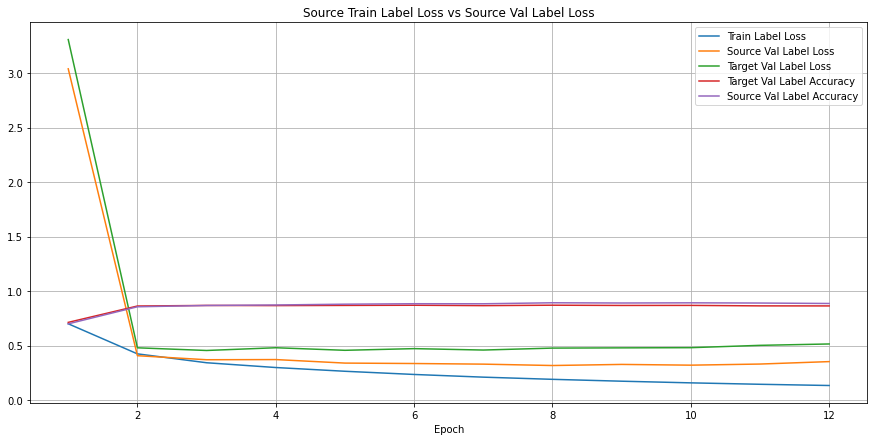

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

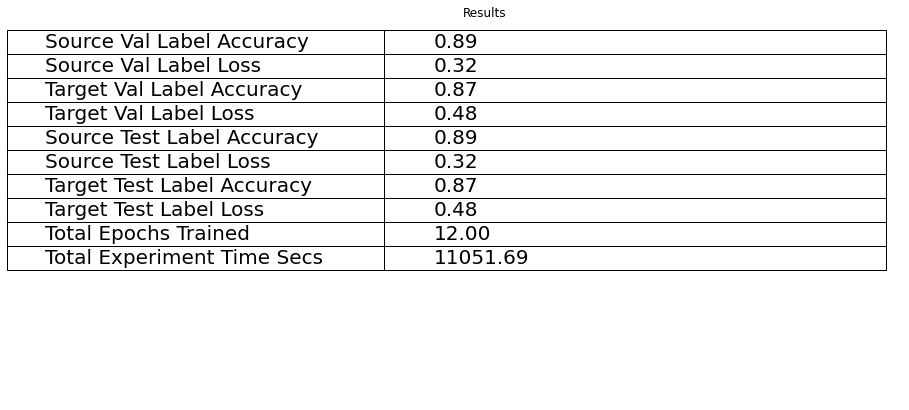

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

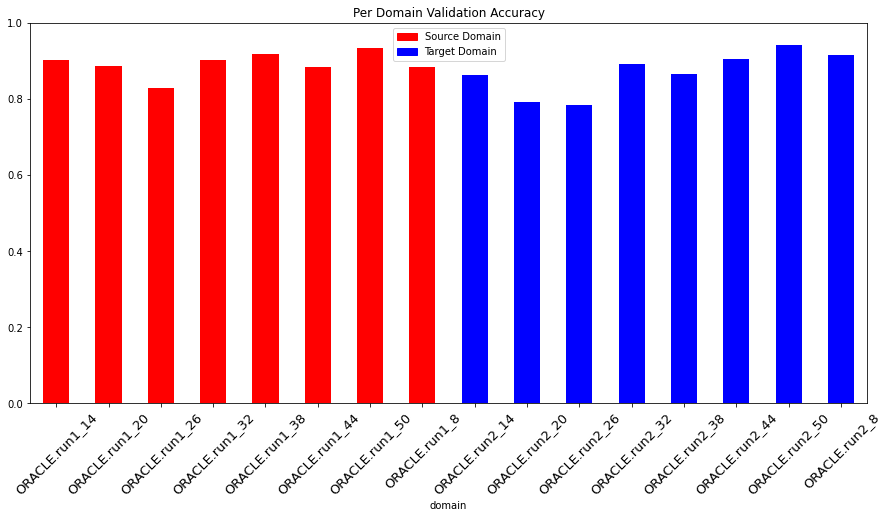

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.8917057291666667 Target Test Label Accuracy: 0.8681575520833333
Source Val Label Accuracy: 0.8922916666666667 Target Val Label Accuracy: 0.87005859375


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1-oracle.run2", "parameters": {"experiment_name": "tl_1v2:oracle.run1-oracle.run2", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}, {"